In this notebook I will try and predict what kind of an incident occured based on where it took place and how long it took to resolve. 

Target: issue_reported(y)
Input vairables: Latitude, Longitude, timespan_min(x)


In [49]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,log_loss, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection, linear_model
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.cluster
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, fbeta_score
from sklearn.pipeline import make_pipeline

Import data of clean features

In [50]:
file = 'traffic_data_features.csv'

In [51]:
df = pd.read_csv(file, index_col=False)
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month,region,lat_from_cntr,lon_from_cntr,dist_from_cntr
0,Crash Service,30.283797,-97.741906,2,144.066667,6,6,cnw,-0.016597,-0.001194,1.849061
1,Traffic Hazard,30.339593,-97.700963,2,64.450000,10,6,vne,-0.072393,-0.042137,9.009002
2,Crash Service,30.329455,-97.638105,4,30.000000,21,4,vce,-0.062255,-0.104995,12.228301
3,Traffic Hazard,30.202806,-97.760701,4,14.183333,21,4,vsw,0.064394,0.017601,7.357232
4,Crash Service,30.184265,-97.687339,4,149.150000,21,4,vse,0.082935,-0.055761,10.665180


In [52]:
df.describe()

,Latitude,Longitude,day,timespan_min,hour,month,lat_from_cntr,lon_from_cntr,dist_from_cntr
count,225445.000000,225445.000000,225445.000000,225445.000000,225445.000000,225445.000000,225445.000000,225445.000000,225445.000000
mean,30.301440,-97.733156,2.906261,49.665617,13.693637,6.980594,-0.034240,-0.009944,11.891963
std,0.094080,0.087511,1.935056,39.684226,7.140035,3.388540,0.094080,0.087511,7.349437
min,30.003883,-98.226709,0.000000,0.333333,0.000000,1.000000,-0.531442,-0.449780,0.007638
25%,30.231715,-97.777183,1.000000,19.500000,9.000000,4.000000,-0.106491,-0.056178,6.060222
50%,30.293602,-97.734450,3.000000,37.500000,15.000000,7.000000,-0.026402,-0.008650,11.071200
75%,30.373691,-97.686922,5.000000,68.516667,20.000000,10.000000,0.035485,0.034083,16.999669
max,30.798642,-97.293320,6.000000,200.000000,23.000000,12.000000,0.263317,0.483609,60.669983


In [53]:
df.issue_reported.value_counts()

Traffic Hazard           92530
Crash Service            85024
COLLISION                25467
Stalled Vehicle          10818
LOOSE LIVESTOCK           5567
COLLISION WITH INJURY     5286
VEHICLE FIRE               753
Name: issue_reported, dtype: int64

In [54]:
df.shape

(225445, 11)

In [59]:
df = df[df["issue_reported"].str.contains("COLLISION|VEHICLE FIRE|COLLISION WITH INJURY|Stalled Vehicle")==False]

In [60]:
df.issue_reported.value_counts()

Traffic Hazard     92530
Crash Service      85024
LOOSE LIVESTOCK     5567
Name: issue_reported, dtype: int64

#  Use Label Encoder for categorical data we are trying to predict
Trying to predict the "issue_reported" involves transforming the column using LabelEncoder(). Then a quick check to ensure the numbers line up like before.

In [46]:
le = LabelEncoder()
df['issue_reported']=le.fit_transform(df['issue_reported'])
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month,region,lat_from_cntr,lon_from_cntr,dist_from_cntr
0,2,30.283797,-97.741906,2,144.066667,6,6,cnw,-0.016597,-0.001194,1.849061
1,5,30.339593,-97.700963,2,64.450000,10,6,vne,-0.072393,-0.042137,9.009002
2,2,30.329455,-97.638105,4,30.000000,21,4,vce,-0.062255,-0.104995,12.228301
3,5,30.202806,-97.760701,4,14.183333,21,4,vsw,0.064394,0.017601,7.357232
4,2,30.184265,-97.687339,4,149.150000,21,4,vse,0.082935,-0.055761,10.665180


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225445 entries, 0 to 225444
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   issue_reported  225445 non-null  int64  
 1   Latitude        225445 non-null  float64
 2   Longitude       225445 non-null  float64
 3   day             225445 non-null  int64  
 4   timespan_min    225445 non-null  float64
 5   hour            225445 non-null  int64  
 6   month           225445 non-null  int64  
 7   region          225445 non-null  object 
 8   lat_from_cntr   225445 non-null  float64
 9   lon_from_cntr   225445 non-null  float64
 10  dist_from_cntr  225445 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 18.9+ MB


In [48]:
df['issue_reported'].unique()

array([2, 5, 1, 4, 0, 3, 6])

In [9]:
df['issue_reported'].value_counts()

5    92530
2    85024
0    25467
4    10818
3     5567
1     5286
6      753
Name: issue_reported, dtype: int64

In [10]:
avg_issue = df.groupby('issue_reported').mean()
avg_issue_span = avg_issue.timespan_min
avg_issue_span

issue_reported
0    42.979385
1    55.196339
2    68.461010
3    42.089731
4    31.433333
5    36.540976
6    45.440106
Name: timespan_min, dtype: float64

In [10]:
median_issue = df.groupby('issue_reported').median()
median_issue_span = median_issue.timespan_min
median_issue_span

issue_reported
0    36.016667
1    50.450000
2    60.466667
3    32.066667
4    22.775000
5    27.000000
6    31.833333
Name: timespan_min, dtype: float64

In [11]:
df['region'].value_counts()

vne    46522
vnw    34619
vcw    29815
vsw    28881
cne    16911
vse    13828
cw     13356
vce    13000
cnw     9623
csw     7660
cse     6366
ce      4864
Name: region, dtype: int64

## Apply LabelEncoder on the new categorical column 'region'.

In [12]:
le2 = LabelEncoder()
df['region']=le2.fit_transform(df['region'])
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month,region,lat_from_cntr,lon_from_cntr,dist_from_cntr
0,2,30.283797,-97.741906,2,144.066667,6,6,2,-0.016597,-0.001194,1.849061
1,5,30.339593,-97.700963,2,64.450000,10,6,8,-0.072393,-0.042137,9.009002
2,2,30.329455,-97.638105,4,30.000000,21,4,6,-0.062255,-0.104995,12.228301
3,5,30.202806,-97.760701,4,14.183333,21,4,11,0.064394,0.017601,7.357232
4,2,30.184265,-97.687339,4,149.150000,21,4,10,0.082935,-0.055761,10.665180


### Drop "Latitude" and "Longitude"

In [13]:
df = df.drop(columns=['Latitude', 'Longitude'])
df.head()

,issue_reported,day,timespan_min,hour,month,region,lat_from_cntr,lon_from_cntr,dist_from_cntr
0,2,2,144.066667,6,6,2,-0.016597,-0.001194,1.849061
1,5,2,64.450000,10,6,8,-0.072393,-0.042137,9.009002
2,2,4,30.000000,21,4,6,-0.062255,-0.104995,12.228301
3,5,4,14.183333,21,4,11,0.064394,0.017601,7.357232
4,2,4,149.150000,21,4,10,0.082935,-0.055761,10.665180


## Scaling Timespan and Latitude/Longitude Features
First, create a series variable using .values

In [14]:
#series1 = df.timespan_min.values
series2 = df.dist_from_cntr.values
series3 = df.lat_from_cntr.values
series4 = df.lon_from_cntr.values

Then reshape the series to scale it as 2D arrays

In [15]:
#series1 = series1.reshape(-1,1)

In [16]:
series2 = series2.reshape(-1,1)

In [17]:
series3 = series3.reshape(-1,1)

In [18]:
series4 = series4.reshape(-1,1)

In [19]:
scaler = StandardScaler()

Then create new columns for for each of the series.

In [20]:
#df['scaled_timespan'] = scaler.fit_transform(series1)

In [21]:
df['scaled_dist'] = scaler.fit_transform(series2)

In [22]:
df['scaled_lat_dist'] = scaler.fit_transform(series3)

In [23]:
df['scaled_lon_dist'] = scaler.fit_transform(series4)

In [24]:

df.head()

,issue_reported,day,timespan_min,hour,month,region,lat_from_cntr,lon_from_cntr,dist_from_cntr,scaled_dist,scaled_lat_dist,scaled_lon_dist
0,2,2,144.066667,6,6,2,-0.016597,-0.001194,1.849061,-1.366489,0.187527,0.099986
1,5,2,64.450000,10,6,8,-0.072393,-0.042137,9.009002,-0.392271,-0.405543,-0.367876
2,2,4,30.000000,21,4,6,-0.062255,-0.104995,12.228301,0.045764,-0.297783,-1.086165
3,5,4,14.183333,21,4,11,0.064394,0.017601,7.357232,-0.617019,1.048402,0.314760
4,2,4,149.150000,21,4,10,0.082935,-0.055761,10.665180,-0.166922,1.245479,-0.523560


In [25]:
dummies = pd.get_dummies(df, columns=['day','hour','month'])

In [26]:
dummies = dummies.drop(columns=[ 'timespan_min', 'dist_from_cntr', 'lat_from_cntr', 'lon_from_cntr'])

In [27]:
dummies.head()

,issue_reported,region,scaled_dist,scaled_lat_dist,scaled_lon_dist,day_0,day_1,day_2,day_3,day_4,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2,2,-1.366489,0.187527,0.099986,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,5,8,-0.392271,-0.405543,-0.367876,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2,6,0.045764,-0.297783,-1.086165,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,5,11,-0.617019,1.048402,0.314760,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,2,10,-0.166922,1.245479,-0.523560,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [28]:
X = dummies

In [29]:

y = df.issue_reported

In [30]:
y.head()

0    2
1    5
2    2
3    5
4    2
Name: issue_reported, dtype: int64

In [32]:
y = pd.Series(y).where(lambda x : x!=2).dropna()

1     5.0
3     5.0
6     5.0
7     5.0
8     5.0
9     5.0
10    5.0
11    1.0
13    4.0
15    5.0
17    5.0
18    5.0
19    5.0
20    5.0
21    5.0
23    0.0
24    4.0
25    5.0
26    5.0
27    5.0
Name: issue_reported, dtype: float64

In [118]:
X.shape

(225445, 48)

In [119]:
y.shape

(225445,)

## Train Test Split and Scale

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

In [121]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:

select = SelectKBest(k=25)
X_train_selected = select.fit_transform(X_train, y_train)

gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train_selected, y_train)
GradientBoostingClassifier(random_state=1)

X_test_selected = select.transform(X_test)
y_pred = gbc.predict(X_test_selected)
accuracy_score(y_test, y_pred)

In [130]:


model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X_train, y_train)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])
mean_squared_error(y_test, model.predict(X_test))

NameError: name 'pipeline' is not defined

In [122]:
rModel = linear_model.LinearRegression(normalize=True)

In [126]:

rModel.fit(X_train, y_train)

/Users/tshields/opt/anaconda3/envs/Springboard/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


LinearRegression(normalize=True)

In [133]:
models = []

models.append(('RFC', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GradientBoostingClassifier()))


In [134]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=None)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RFC: 0.603797 (0.007903)
KNN: 0.505219 (0.007158)
NB: 0.596514 (0.007246)


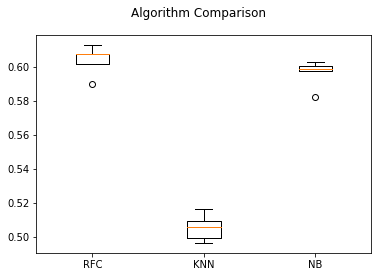

In [135]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Random Forest Hyperparamter Tuning

In [136]:
forest = RandomForestClassifier()

In [138]:
n_estimators = [100, 300, 500, 800]
max_depth = [5, 8, 15, 25]
min_samples_split = [2, 5, 10, 15]


hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             )

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


In [139]:
print('Best n_estimators:', bestF.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', bestF.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', bestF.best_estimator_.get_params()['min_samples_split'])

Best n_estimators: 800
Best max_depth: 25
Best min_samples_split: 2


In [140]:
forestOpt = RandomForestClassifier(random_state = 1, max_depth = 25, n_estimators = 800, min_samples_split = 2)
                                   
modelOpt = forestOpt.fit(X_train, y_train)
y_pred = modelOpt.predict(X_test)

## Attempting to perform a confusion matrix on Random Forest model

In [151]:

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


In [153]:
cm = confusion_matrix(y_test, y_pred)

/Users/tshields/opt/anaconda3/envs/Springboard/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


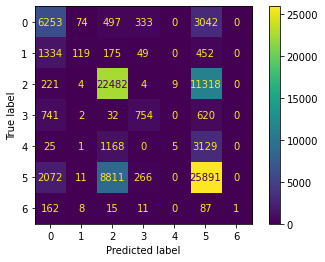

In [156]:

plot_confusion_matrix(modelOpt, X_test, y_test)  
plt.show() 

In [158]:
df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
df

,Real Values,Predicted Values
201927,2,2
25560,0,0
27432,5,2
87182,2,2
181100,2,2
...,...,...
39486,2,2
211582,2,2
57044,3,0
72715,0,0


In [171]:
print('LR Accuracy Score: ', accuracy_score(y_test , y_pred))
print('LR Precision Score: ', precision_score(y_test, y_pred, pos_label='positive', average='micro'))
print('LR Recall Score: ', recall_score(y_test, y_pred, pos_label='positive', average='micro'))
print('LR F1 Score: ', f1_score(y_test, y_pred, pos_label='positive', average='micro'))
print('LR F0.5-Measure: ', fbeta_score(y_test, y_pred, beta=0.5, pos_label='positive', average='micro'))
print('LR Confusion Matrix: \n\n', confusion_matrix(y_test , y_pred))
print('LR Classification Report: \n\n', classification_report(y_test, y_pred))

LR Accuracy Score:  0.6155048903280179
LR Precision Score:  0.6155048903280179
LR Recall Score:  0.6155048903280179
LR F1 Score:  0.6155048903280179
LR F0.5-Measure:  0.6155048903280179
LR Confusion Matrix: 

 [[ 6253    74   497   333     0  3042     0]
 [ 1334   119   175    49     0   452     0]
 [  221     4 22482     4     9 11318     0]
 [  741     2    32   754     0   620     0]
 [   25     1  1168     0     5  3129     0]
 [ 2072    11  8811   266     0 25891     0]
 [  162     8    15    11     0    87     1]]
LR Classification Report: 

               precision    recall  f1-score   support

           0       0.58      0.61      0.60     10199
           1       0.54      0.06      0.10      2129
           2       0.68      0.66      0.67     34038
           3       0.53      0.35      0.42      2149
           4       0.36      0.00      0.00      4328
           5       0.58      0.70      0.63     37051
           6       1.00      0.00      0.01       284

    accurac

/Users/tshields/opt/anaconda3/envs/Springboard/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Users/tshields/opt/anaconda3/envs/Springboard/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Users/tshields/opt/anaconda3/envs/Springboard/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Users/tshields/opt/anaconda3/envs/Springboard/lib/python3.8/site-packages/sklearn/metri

## For some reason all my scores are the same: 0.6155048903280179